In [ ]:
import os
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf

In [ ]:
data_dir = '/content/drive/MyDrive/Waste_Classification_Project/WasteData/Garbage classification/Garbage classification'

In [ ]:
classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
for c in classes:
  count = len(os.listdir(os.path.join(data_dir, c)))
  print(f'{c} : {count}')

cardboard : 403
glass : 501
metal : 410
paper : 594
plastic : 482
trash : 137


In [ ]:
img_height = 224
img_width = 224
batch_size = 32


train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = "training",
                                                       seed = 123,
                                                       image_size = (img_height, img_width),
                                                       batch_size = batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = "validation",
                                                       seed = 123,
                                                       image_size = (img_height, img_width),
                                                       batch_size = batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models

In [ ]:
base_model = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

num_classes = len(classes)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

In [ ]:
import numpy as np
import  seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


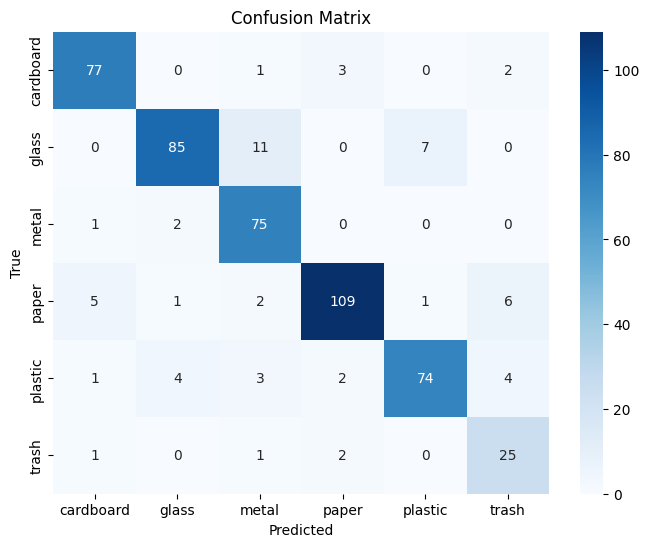

              precision    recall  f1-score   support

   cardboard       0.91      0.93      0.92        83
       glass       0.92      0.83      0.87       103
       metal       0.81      0.96      0.88        78
       paper       0.94      0.88      0.91       124
     plastic       0.90      0.84      0.87        88
       trash       0.68      0.86      0.76        29

    accuracy                           0.88       505
   macro avg       0.86      0.88      0.87       505
weighted avg       0.89      0.88      0.88       505



In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert to numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Ensure same length
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=classes))

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_true),
    y=y_true
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(1.0140562248995983), 1: np.float64(0.8171521035598706), 2: np.float64(1.079059829059829), 3: np.float64(0.678763440860215), 4: np.float64(0.9564393939393939), 5: np.float64(2.9022988505747125)}


In [ ]:
base_model.trainable = True

fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stop, lr_schedule]
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 175ms/step - accuracy: 0.2040 - loss: 2.2629 - val_accuracy: 0.2455 - val_loss: 2.0227 - learning_rate: 1.0000e-05
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.3058 - loss: 1.8718 - val_accuracy: 0.3010 - val_loss: 1.7873 - learning_rate: 1.0000e-05
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.3729 - loss: 1.6118 - val_accuracy: 0.3782 - val_loss: 1.5884 - learning_rate: 1.0000e-05
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.4688 - loss: 1.3603 - val_accuracy: 0.4653 - val_loss: 1.4023 - learning_rate: 1.0000e-05
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.5280 - loss: 1.2529 - val_accuracy: 0.5386 - val_loss: 1.2532 - learning_rate: 1.0000e-05
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.5618 - loss: 1.1265 - val_accuracy: 0.5921 - val_loss: 1.1323 - learning_rate: 1.0000e-05
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - ac

In [ ]:
val_loss,   val_acc = model.evaluate(val_ds)
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Validation Loss: {val_loss:.2f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8612 - loss: 0.3742
Validation Accuracy: 86.73%
Validation Loss: 0.39


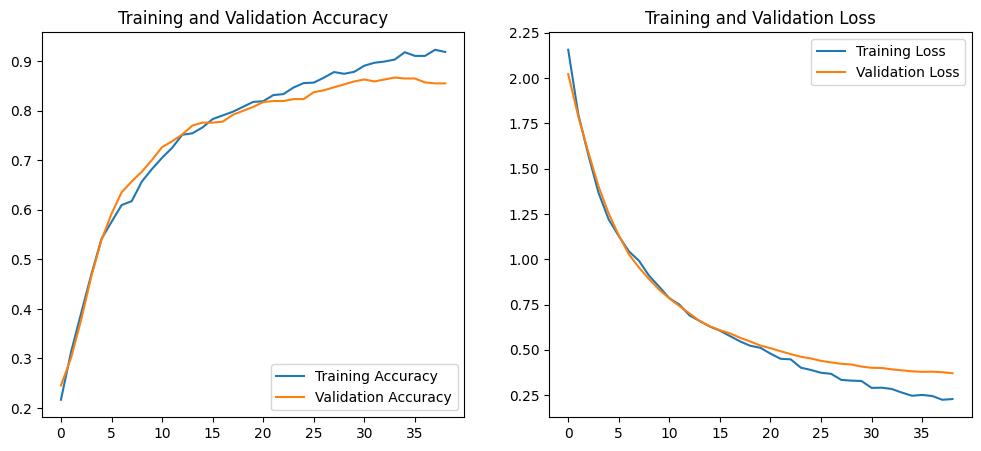

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
@app.route("/predict", methods=["POST"])
def predict():
    try:
        if "file" not in request.files:
            return jsonify({"error": "No file uploaded"}), 400

        file = request.files["file"]
        img = Image.open(io.BytesIO(file.read())).convert("RGB")
        img = img.resize((180,180))  # resize same as training
        arr = np.array(img) / 255.0  # normalize
        arr = np.expand_dims(arr, 0)  # batch dimension

        preds = model.predict(arr)
        idx = int(np.argmax(preds[0]))
        conf = float(np.max(preds[0]))

        return jsonify({
            "class": class_names[idx],
            "confidence": conf,
            "all_probs": {class_names[i]: float(preds[0][i]) for i in range(len(class_names))}
        })
    except Exception as e:
        return jsonify({"error": str(e)})


NameError: name 'app' is not defined

In [ ]:
model.save("/content/drive/MyDrive/garbage_classifier.h5")

